In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data[f'ema_{periods}'] = data.ema_diff / vol 
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    #data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 1000
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
sym = 'ES'
start_date='20180801'
end_date='20191231'
periods=[5,10,20,40,80,160]
inds = {
    'bollir': run(sym, bolli_reduced, start_date=start_date, end_date=end_date, periods=periods), 
    'ema': run(sym, ema, start_date=start_date, end_date=end_date, periods=periods), 
    'breakout': run(sym, breakout, start_date=start_date, end_date=end_date, periods=periods),
    'carver': run(sym, carver, start_date=start_date, end_date=end_date, periods=periods),
    #'roc': run(sym, roc, start_date=start_date, end_date=end_date, periods=periods)
}
weights = {
    'bollir': .5, 
    'ema': .25, 
    'breakout': .25,
    #'carver': .1,
    #'roc': .1,
}

In [10]:
out = pd.DataFrame(columns=['mean', 'std'])
for key, ind in inds.items():
    out.loc[key, 'mean'] = ind.forecast.abs().mean()
    out.loc[key, 'std'] = ind.forecast.abs().std()
out

,mean,std
bollir,9.50772,6.07108
ema,10.768,6.22874
breakout,9.77107,6.48219
carver,7.33449,4.73667


In [11]:
c=pd.DataFrame({key: ind.forecast for key, ind in inds.items()}).corr()
c

,bollir,ema,breakout,carver
bollir,1.000000,0.783637,0.944663,0.943160
ema,0.783637,1.000000,0.748421,0.811586
breakout,0.944663,0.748421,1.000000,0.936305
carver,0.943160,0.811586,0.936305,1.000000


In [12]:
c.sum()

bollir      3.671460
ema         3.343643
breakout    3.629388
carver      3.691051
dtype: float64

In [13]:
def combine(inds, weights=None):
    if weights is None:
        weights = {key: 1/len(inds) for key in inds.keys()}
    assert round(sum(weights.values()),4) == 1.0, "Weights don't add up to 1"
    df = pd.DataFrame({name: df.forecast for name, df in inds.items()})
    df['forecast'] = (df*pd.Series(weights)).sum(axis=1)
    df[['open', 'close']] = inds[list(inds.keys())[0]][['open', 'close']]
    #multiplier = 10/df.forecast.abs().std()
    multiplier = 1
    df['forecast'] = df.forecast * multiplier
    return df

In [14]:
data=combine(inds,)

In [15]:
data.forecast.abs().mean(), data.forecast.abs().std()

(8.846643842775904, 5.494302898119078)

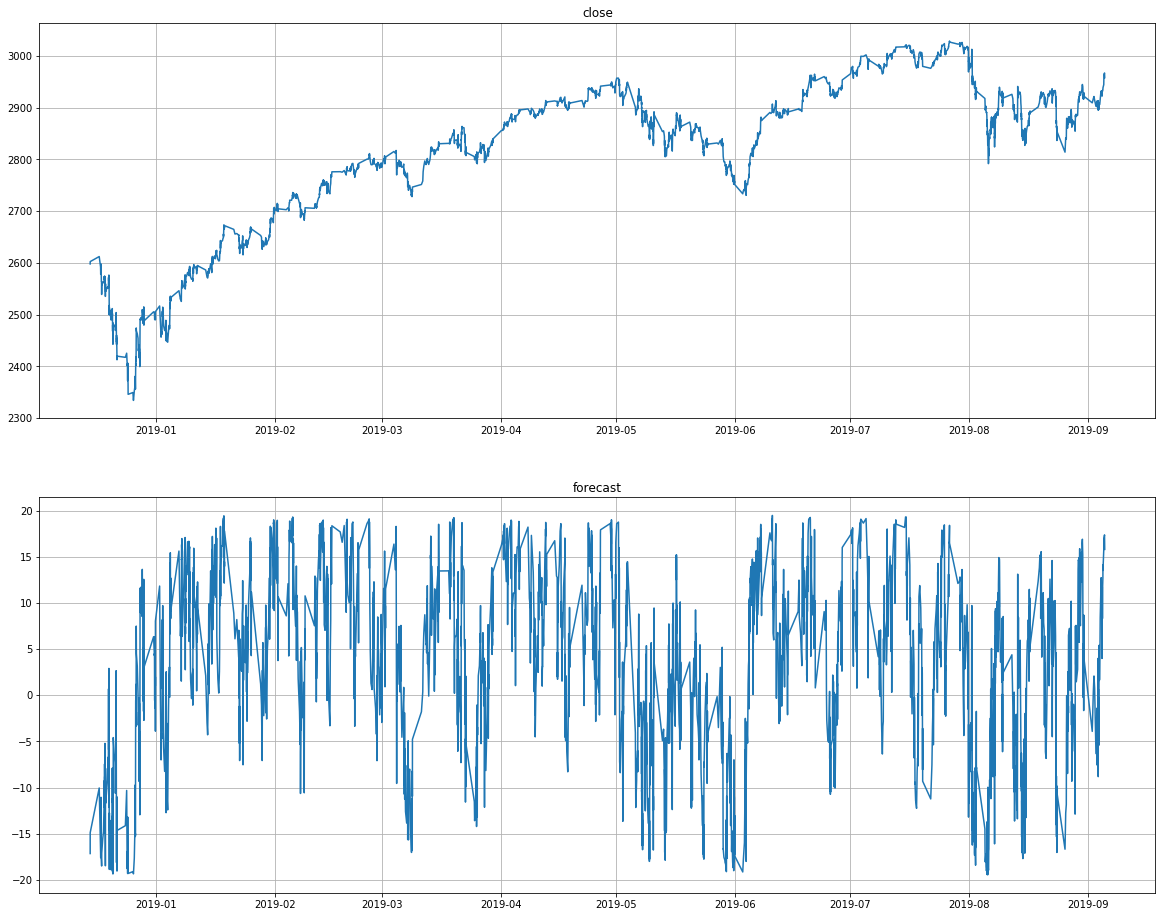

In [16]:
plot(data[['close', 'forecast']])

In [17]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.223678,0.200323,0.209068,0.163524,0.102362,-0.0186411,-0.0430915,-0.0589132,0.00443575
Cumulative returns,0.165323,0.148425,0.154762,0.12164,0.0766609,-0.0141609,-0.0328341,-0.0449789,0.00336022
Annual volatility,0.130048,0.112014,0.102358,0.100999,0.0975128,0.0954185,0.054275,0.0408495,0.0240611
Sharpe ratio,1.61745,1.68618,1.90617,1.55005,1.04793,-0.14975,-0.784577,-1.4659,0.195886
Calmar ratio,2.5275,2.75293,4.67268,2.86101,1.6117,-0.236677,-0.722813,-1.01334,0.301979
Stability,0.261135,0.381963,0.740696,0.473975,0.0597785,0.397108,0.602665,0.795742,0.00122953
Max drawdown,-0.0884979,-0.0727669,-0.0447427,-0.0571559,-0.0635114,-0.0787618,-0.0596164,-0.0581376,-0.0146889
Omega ratio,1.31592,1.32751,1.38642,1.32134,1.20481,0.971229,0.822256,0.650171,1.11338
Sortino ratio,2.46685,2.85104,3.36787,2.67632,1.76524,-0.215787,-1.17995,-1.90134,0.331908
Skew,0.0198532,0.602105,0.761418,0.758448,0.791926,0.106224,1.42148,-0.672346,2.3937


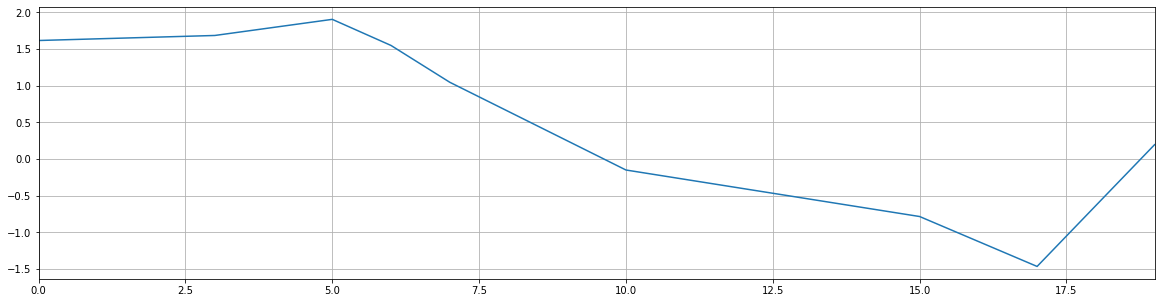

In [18]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [19]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.885738,0.817813,0.782069,0.736857,0.535206,0.328671,0.250597,0.146879
3,0.885738,1.000000,0.919108,0.855103,0.819720,0.601473,0.395653,0.314528,0.166230
5,0.817813,0.919108,1.000000,0.935474,0.879256,0.646556,0.405740,0.350233,0.184684
6,0.782069,0.855103,0.935474,1.000000,0.940584,0.720143,0.431699,0.367341,0.211454
7,0.736857,0.819720,0.879256,0.940584,1.000000,0.824668,0.503613,0.418274,0.239868
10,0.535206,0.601473,0.646556,0.720143,0.824668,1.000000,0.567308,0.504558,0.316174
15,0.328671,0.395653,0.405740,0.431699,0.503613,0.567308,1.000000,0.697706,0.534686
17,0.250597,0.314528,0.350233,0.367341,0.418274,0.504558,0.697706,1.000000,0.434660
19,0.146879,0.166230,0.184684,0.211454,0.239868,0.316174,0.534686,0.434660,1.000000


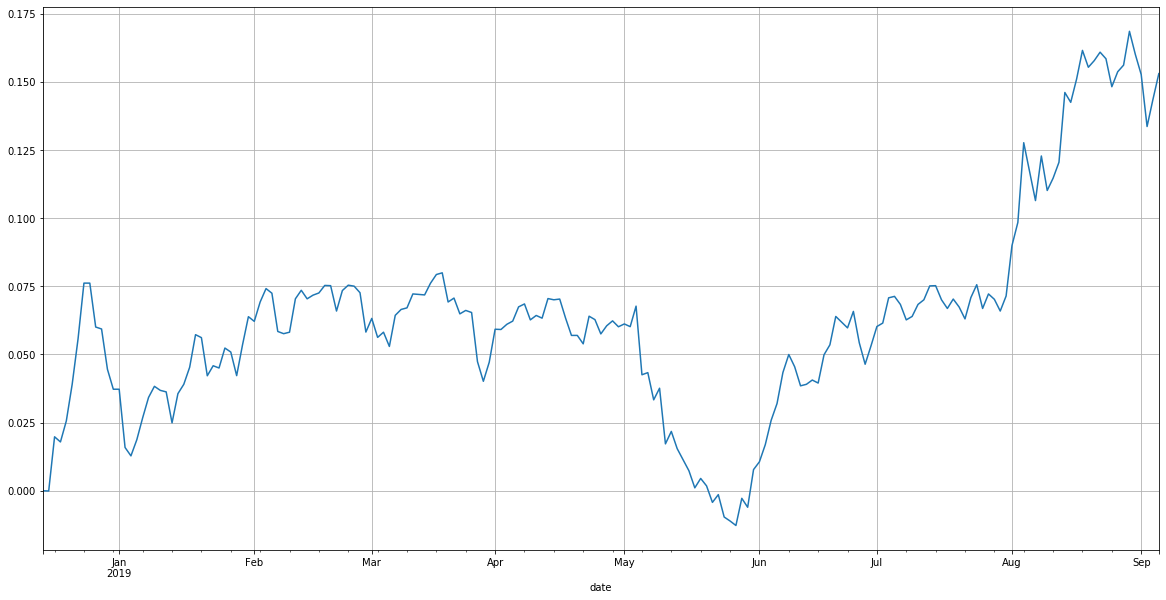

In [20]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

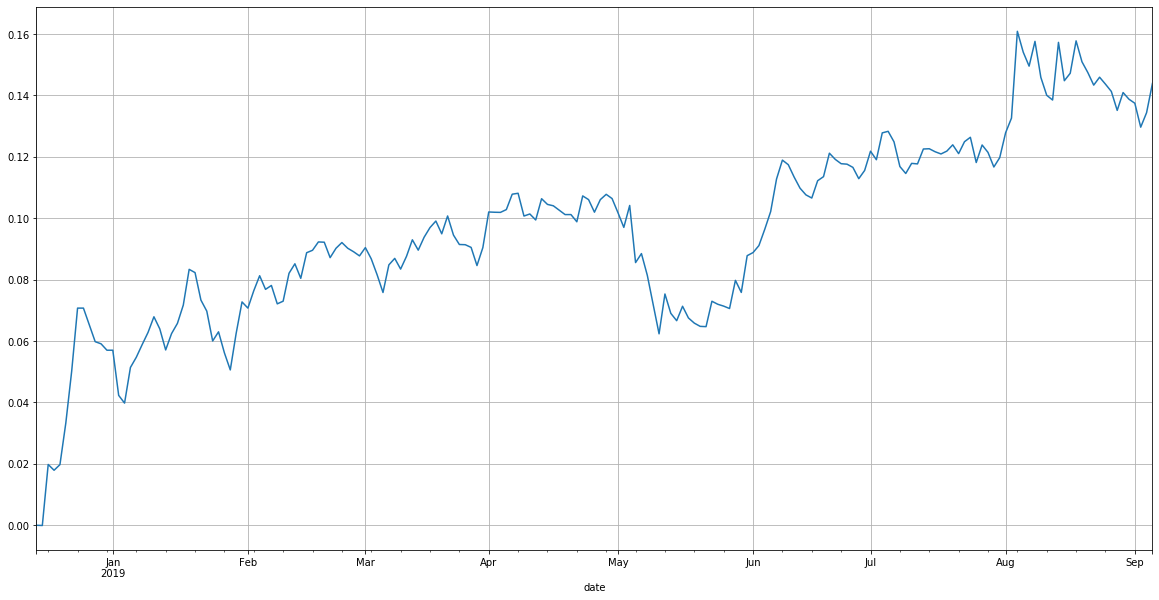

In [21]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

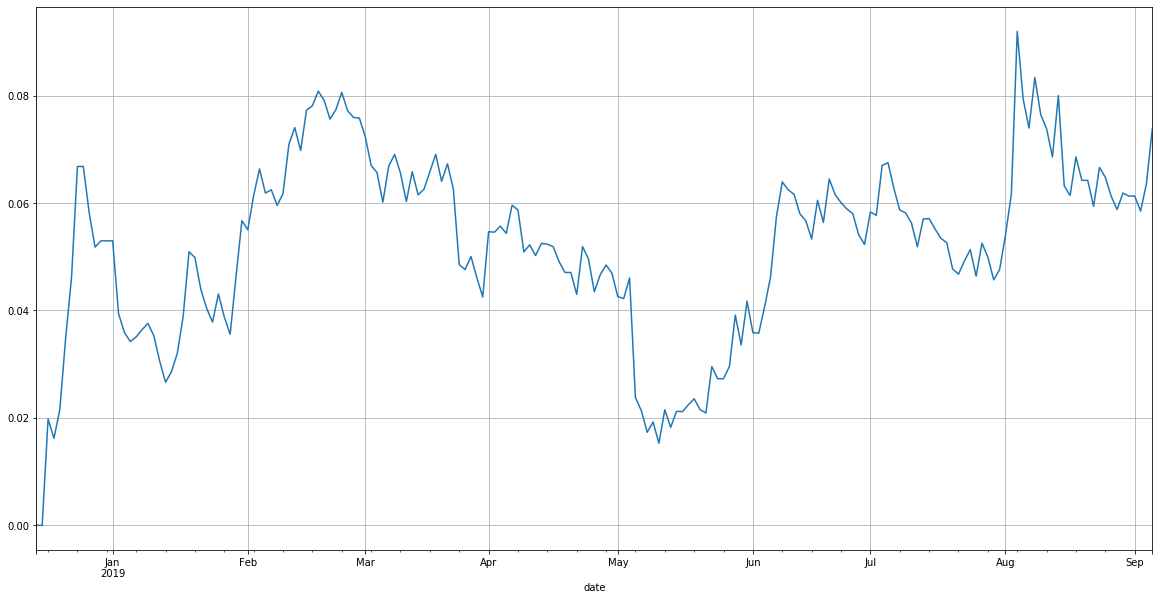

In [22]:
np.log(out.returns[7]+1).cumsum().plot(figsize=(20, 10), grid=True);

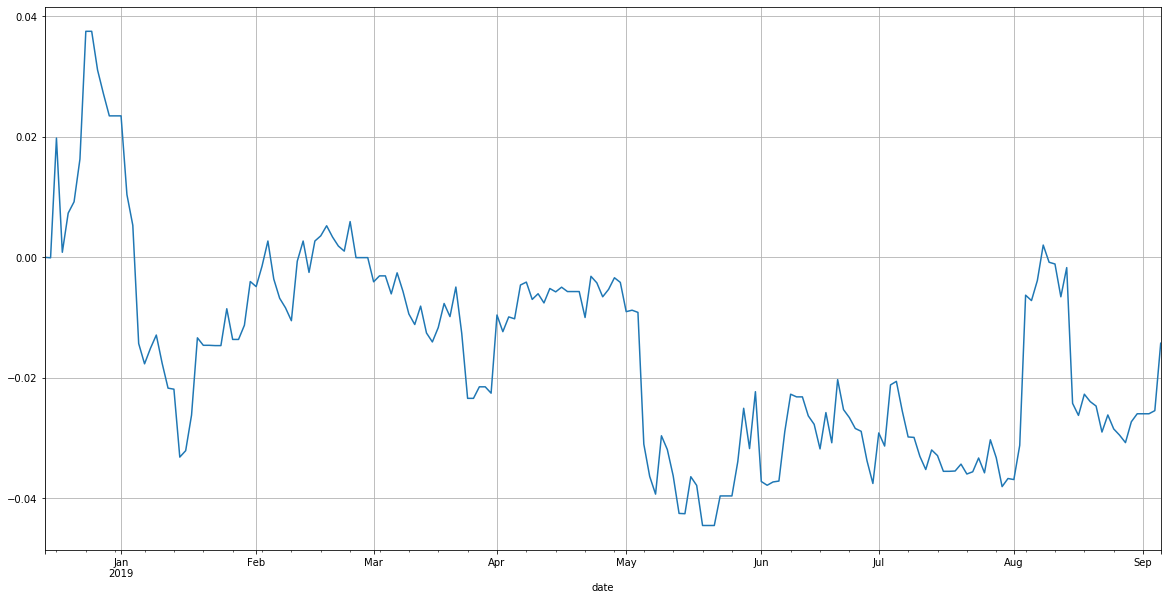

In [23]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);